### Potential example
An example notebook for reconstructing a high-dimensional neural network potential (HDNNP). 

In [1]:
!gpustat

sasdsnode01.vito.local    Tue Jan  3 10:13:48 2023  510.108.03
[0] NVIDIA A100-PCIE-40GB | 33'C,   0 % |   605 / 40960 MB |


In [2]:
# %env JAX_ENABLE_X64=1
%env JAX_PLATFORM_NAME=cpu
# %env JAX_DISABLE_JIT=1
# %env JAX_DEBUG_NANS=1
# %env TF_CPP_MIN_LOG_LEVEL=0
# %env xla_force_host_platform_device_count=16

env: JAX_PLATFORM_NAME=cpu


In [3]:
from mlpot.types import dtype as default_dtype
import jax.numpy as jnp
import jax
# default_dtype.FLOATX = jnp.float64
print(f"{default_dtype.FLOATX=}")

MLPOT default_dtype.FLOATX=<class 'jax.numpy.float32'>


### Imports

In [18]:
import logging
import numpy as np
from pathlib import Path
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict
# from torch.utils.data import DataLoader

import mlpot
from mlpot import logger
from mlpot.types import dtype as default_dtype
from mlpot.datasets import RunnerStructureDataset
from mlpot.potentials import NeuralNetworkPotential
from mlpot.logger import LoggingContextManager

In [5]:
# mlpot.logger.set_logging_level(logging.DEBUG)

# print(mlpot.__doc__)
# print(f"version: {mlpot.__version__}")

## Dataset

In [6]:
base_dir = Path('./LJ')

In [7]:
structures = RunnerStructureDataset(Path(base_dir, "input.data"), persist=True) #, transform=lambda x: x) 
# structures = RunnerStructureDataset(Path(base_dir, "input.data"), transform=ToStructure(r_cutoff=3.0), persist=True) 
print("Total number of structures:", len(structures))
structures

Total number of structures: 101


RunnerStructureDataset(filename=PosixPath('LJ/input.data'), persist=True, transform=ToStructure())

In [8]:
structures = [structures[i] for i in range(100)]

In [9]:
s = structures[0]
s

Structure(natoms=2, elements=('Ne',), dtype=float32)

In [10]:
# with LoggingContextManager(level=logging.DEBUG):
# structures[0].to_dict()

## Potential

In [12]:
nnp = NeuralNetworkPotential(Path(base_dir, "input.nn"))
nnp

NeuralNetworkPotential(potfile='input.nn')

##### Extrapolation warnings

In [ ]:
# nnp.set_extrapolation_warnings(100)

##### Fit scaler

In [13]:
nnp.fit_scaler(structures)

Fitting descriptor scalers...


100%|██████████| 100/100 [00:01<00:00, 90.76it/s]

Done.



#### Train

In [14]:
time nnp(s)

CPU times: user 309 ms, sys: 9.86 ms, total: 318 ms
Wall time: 290 ms


Array(0.37806588, dtype=float32)

Epoch 1 of 10


100%|██████████| 100/100 [00:01<00:00, 55.21it/s]


training loss: 0.1368940

Epoch 2 of 10


100%|██████████| 100/100 [00:00<00:00, 222.94it/s]


training loss: 0.2304020

Epoch 3 of 10


100%|██████████| 100/100 [00:00<00:00, 219.98it/s]


training loss: 0.1139796

Epoch 4 of 10


100%|██████████| 100/100 [00:00<00:00, 220.59it/s]


training loss: 0.1237702

Epoch 5 of 10


100%|██████████| 100/100 [00:00<00:00, 222.13it/s]


training loss: 0.4367188

Epoch 6 of 10


100%|██████████| 100/100 [00:00<00:00, 220.04it/s]


training loss: 0.1646622

Epoch 7 of 10


100%|██████████| 100/100 [00:00<00:00, 223.03it/s]


training loss: 0.7726274

Epoch 8 of 10


100%|██████████| 100/100 [00:00<00:00, 223.48it/s]


training loss: 0.0969225

Epoch 9 of 10


100%|██████████| 100/100 [00:00<00:00, 223.69it/s]


training loss: 0.0990495

Epoch 10 of 10


100%|██████████| 100/100 [00:00<00:00, 224.15it/s]


training loss: 0.1491085



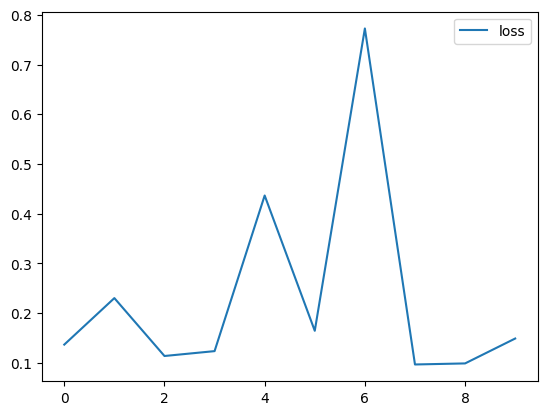

In [15]:
h = nnp.fit_model(structures, epochs=10, batch_size=1)

for sub in h:
    if 'loss' in sub:
        plt.plot(h['epoch'], h[sub], label=sub)
plt.legend();

##### Validation

len(structures)=100


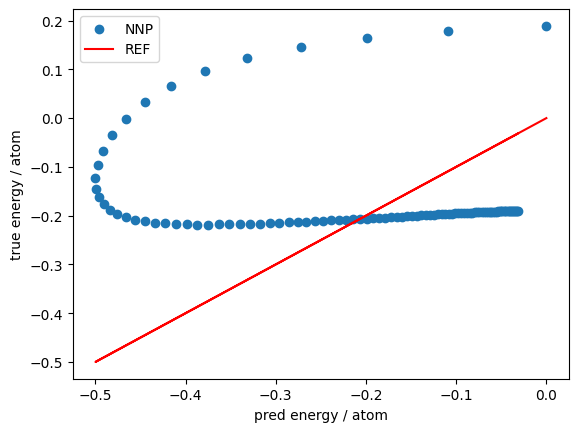

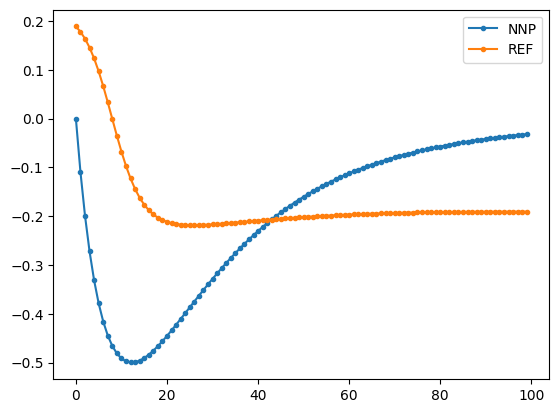

In [16]:
print(f"{len(structures)=}")
true_energy = [s.total_energy/s.natoms for s in structures]
pred_energy = [nnp(s)/s.natoms for s in structures]
ii = range(len(structures))
plt.scatter(true_energy, pred_energy, label='NNP')
plt.plot(true_energy, true_energy, 'r', label="REF")
plt.xlabel("pred energy / atom")
plt.ylabel("true energy / atom")
plt.legend()
plt.show()

if "Ne" in nnp.elements:
    plt.plot(ii, true_energy, '.-', label="NNP");
    plt.plot(ii, pred_energy, '.-', label="REF");
    plt.legend()
    plt.show()

len(structures)=100


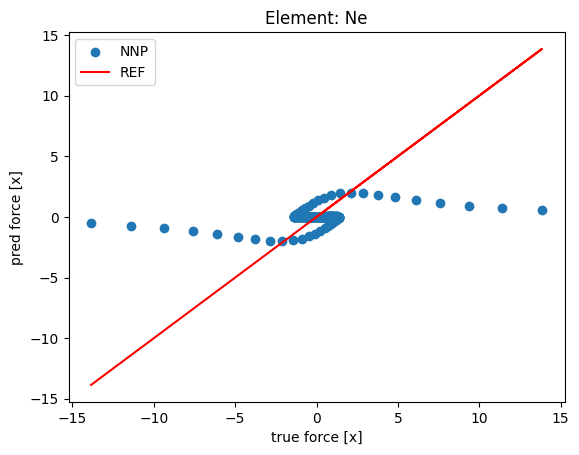

In [20]:
import jax.numpy as jnp

true_forces = defaultdict(list)
pred_forces = defaultdict(list)

print(f"{len(structures)=}")
for structure in structures:
    true_forces_per_structure = structure.get_forces()
    pred_forces_per_structure = nnp.compute_force(structure)

    for element in nnp.elements:
        true_forces[element].append(true_forces_per_structure[element])
        pred_forces[element].append(pred_forces_per_structure[element])

dim = 0
to_axis = {d: c for d, c in enumerate('xyz')}
for element in nnp.elements:
    true_forces[element] = jnp.concatenate(true_forces[element], axis=0)
    pred_forces[element] = jnp.concatenate(pred_forces[element], axis=0)

    plt.scatter(true_forces[element][:, dim], pred_forces[element][:, dim], label='NNP')
    plt.plot(true_forces[element][:, dim], true_forces[element][:, dim], 'r', label='REF')
    plt.title(f"Element: {element}")
   
    label= f"force [{to_axis[dim]}]"
    plt.ylabel("pred " + label)
    plt.xlabel("true " + label)
    plt.legend()
    plt.show()
    

### Experiments

#### Saving model

In [2]:
# import json
# import jax.numpy as jnp

# d = nnp.model_params["Ne"]

# with open('model.pkl', 'wb') as file:
#     # jnp.save(file, d['layers_0']['kernel'])
#     jnp.savez(file, x=d['layers_0']['kernel'], z=d['layers_0']['bias'])
#     # json.dump(d.unfreeze(), file)
    
# with open('model.pkl', 'rb') as file:  
#     dp = jnp.load(file)
#     print(dp['x'])

#### Descriptors

##### Profiling

In [ ]:
# import cProfile
# profile = cProfile.Profile()

In [ ]:
# profile.runcall(nnp.fit_scaler, structures)
# profile.print_stats(sort='cumtime')

#### Training

In [ ]:
# %time history = nnp.fit_model(structures, epochs=100, validation_split=0.1) # validation_split=0.20)
# %time history = nnp.fit_model(train_structures, epochs=10, validation_dataset=valid_structures)
# %time history = profile(nnp.fit_model, structures, epochs=0, validation_split=0.20)
# nnp.load_model()

In [ ]:
# nnp.extrapolation_warnings

##### Loss and error metrics

##### Observations
- force values are fine
- energy values are noticible different (w.r.t. N2P2) - probbaly the training algorithm has to be improved
- need a toolset to make the N2P2 comparision and validation of forces, energy, descriptor, etc easier and faster.

In [1]:
# fig, ax = plt.subplots(1, 3, figsize=(12,4))

# df = pd.DataFrame(history)
# df[["train_loss", "valid_loss"]][:].plot(ax=ax[0]);
# df[[f"train_energy_error", f"valid_energy_error"]][:].plot(ax=ax[1]);
# df[["train_force_error", f"valid_force_error"]][:].plot(ax=ax[2]);
# plt.tight_layout()
# df.tail()

##### Energy and Forces

In [ ]:
# fig, ax = plt.subplots(3, 2, figsize=(11,8))
# EV_TO_HARTREE = 0.0367493
# ENERGY_ERR    = 2.0E-3*EV_TO_HARTREE  # 2.0 meV/atom
# FORCE_ERR     = 0.1*EV_TO_HARTREE     # 0.1 eV/Bohr

# df.plot(x='r', y=['E_pred', 'E_true'], ax=ax[0][0], style='.-', lw=0.5)
# df.plot(x='r', y=['E_error'], ax=ax[1][0], style='.-', lw=0.5); 
# df.plot.hist(y=['E_err/atom'], ax=ax[2][0])

# df.plot(x='r', y=['F_pred', 'F_true'], ax=ax[0][1], style='.-', lw=0.5)
# df.plot(x='r', y=['F_error'], ax=ax[1][1], style='.-', lw=0.5)
# df.plot.hist(y=['F_err'], ax=ax[2][1]);

# if str(err_metric) == "RMSEpa":
#     ax[1][0].axhline(ENERGY_ERR, ls='--', c='r'); print(f"Eenergy Thrsh.: {ENERGY_ERR:.10f}")
#     ax[1][1].axhline(FORCE_ERR, ls='--', c='r');  print(f"Force   Thrsh.: {FORCE_ERR:.10f}")
# plt.tight_layout()